## Section 1: Setup & Load Results

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
import random # NEW! For Agents
warnings.filterwarnings('ignore', category=UserWarning)

np.random.seed(99) # Set random seed for reproducibility
random.seed(99)

df = pd.read_csv('../data/bilat_mig.csv')# Load the migration data
# Rebuild the directed graph
G = nx.DiGraph()
for index, row in df.iterrows():
    if row['da_pb_closed'] > 0:
        G.add_edge(row['orig'], row['dest'], weight=row['da_pb_closed'])
print("Libraries loaded and graph rebuilt successfully!")
print(f"Graph: {G.number_of_nodes()} countries, {G.number_of_edges()} migration flows")

Libraries loaded and graph rebuilt successfully!
Graph: 10 countries, 88 migration flows


# 2. Event Testing
Early in development, some key characteristics were chosen to model, as described in https://www.europarl.europa.eu/topics/en/article/20200624STO81906/exploring-migration-causes-why-people-migrate \
Gross Domestic Product per capita (GDP) was expected to be an important metric when simulating.\
Some way of simulating war or humanitarian crisis was also expected to be important in matching real-world behaviour.

Testing was completed for an "event" based system, where events, such as wars or natural disasters, would randomly occur in a country.\
This would add a negative modifier to the decision making of all Migrants, which would skew them towards migrating away.

This code did not make it into the final model, as it was found that Human Development Index (HDI) data already accounted well for ongoing wars and events.\
Additionally, random events make the model non-deterministic, and makes it difficult for the model to reach equilibrium.

A working version of the code is kept here for posterity.

## 2. Agent setup:
This is a copy of an earlier version of the random decision-making Agent. Please see notebook 05 for more information.

In [22]:
class Agent:
    """
    Represents an individual migrant agent.
    
    Attributes:
        id              - The "name" of this agent
        birth_place     - The source of this agent
        living_place    - The current living place
        age             - Fill later
        wanderlust      - threshold to move per step
        locations       - A list of all locations lived in. If it doesn't move, a duplicate is added
    """
    

    def __init__(self, id, birth_country):
        """
        Initialize a new migrant agent.
        
        Args:
            agent_id: Unique identifier for this agent
            birth_country: Starting country (string, country code)
            params: Dictionary of model parameters
        """
        self.birth_place = birth_country
        self.living_place = birth_country
        self.age = 0
        self.wanderlust = 0.3
        self.id = id
        self.locations = []

    # ------ Cost Functions -------
    def check_if_move(self, world):
        """
        Decide whether to migrate this timestep.
        
        BASELINE VERSION: Random threshold (Seb's random approach)
        Later models will use economic factors, network effects, etc.
        
        Args:
            world: MigrationWorld object (access to environment info)
            
        Returns:
            Boolean: True if agent decides to migrate
        """
        if(random.random() < self.wanderlust):
            return True
        else:
            return False

    def check_where_move(self, world):
        """
        Choose which country to migrate to.
        
        BASELINE VERSION: Random choice from neighbors (Seb's approach)
        Later models will use attractiveness, diaspora, distance costs.
        
        Args:
            world: MigrationWorld object
            
        Returns:
            String: Country code of destination
        """

        # Check valid neighbours
        possible_countries = world.get_neighbours(self.living_place)

        # Get a random one for now
        new_country = random.choice(list(possible_countries))

        return new_country
    


    def step(self, world, display=False):
        """
        Execute one timestep for this agent.
        
        Follows Lab 6 Sugarscape + Seb's Agent.step() pattern:
        1. Increment age
        2. Decide whether to migrate
        3. If yes, choose destination and move
        4. Record new location in history
        
        Args:
            world: MigrationWorld object
        """
        self.age += 1

        if(self.check_if_move(world)):
            new_country = self.check_where_move(world)

            # Printouts
            if(display): 
                print("Checking", self.id, 
                "... I live in ", self.living_place, 
                "and I hate it. I'm moving to:", new_country)
        
        else:
            new_country = self.living_place

            # Printouts
            if(display): 
                print("Checking", self.id, 
                "... I live in ", self.living_place, 
                "and I'm happy here")
            
        
        # Add the new location to the array
        self.living_place = new_country
        self.locations.append(new_country)

## World with Events
This is a copy of the random-based World object. Again, please see Notebook 05 for a more detailed analysis.\
Additional code also models natural disasters and war as random "Events".

Placeholders were left in the methods for both "Severity" and "Extent" for new events.\
Later these were intended to be expanded, to allow for events that don't provide as much of a downside or affect everyone in the country.\
Examples could include a magnitude 2 earthquake, or an extremely localised war.

In [23]:
class World:

    # --------------------------
    # --- NEW: Updated Init ---
    # --------------------------
    def __init__(self, world_graph):
        """
        Initialize the migration world.
        
        Args:
            graph: NetworkX DiGraph of migration network
        """
        # Add list of agents
        self.agents      = []

        # Add the world graph
        self.world_graph = world_graph

        # --- NEW: Initialise the event lists. Start with nothing ---
        for node in world_graph.nodes:
            # Edit the actual node object, not the string name
            self.get_node(node)["event"] = None

    def get_node(self, node_name):
        """
        Retrieve the actual node object from a given name. Allows editting and retrieval of node parameters.

        Params:
            A country code

        Returns:
            The associated node object
        """
        return self.world_graph.nodes[node_name]

    def get_rand_country(self):
        """
        Get a Random country in the network
            
        Returns:
            A country code
        """
        random_item = random.choice(list(self.world_graph.nodes))
        return random_item
    
    def get_neighbours(self, node):
        """
        Get countries reachable from given country.
        
        Args:
            node: Country code (string)
            
        Returns:
            Iterator of neighbor country codes
        """
        return self.world_graph.neighbors(node)

    def add_agent(self):
        """
        Create and add migrants to the world.
        
        Based on Seb's add_agent() + Lab 6 make_agents() pattern.
        Agents are initialized in random countries.
        """
        new_id = len(self.agents) + 1
        rand_birth_place = self.get_rand_country()
        new_agent = Agent(new_id, rand_birth_place)

        print("Adding new agent born in ", rand_birth_place)
        self.agents.append(new_agent)

    def get_agents(self):
        """
        Retrieve all Agents linked to this World
        
        Returns:
            Iterator of Agents associated with this World
        """
        return self.agents
    



    # --------------------------
    # --- NEW: Event methods ---
    # --------------------------

    def check_event(self, node):
        """
        If there's no currently active event, check if one starts.
        If there is an event, check if it ends.

        Params:
            node: The country Code for the target country
        """
        event_chance = 0.1 # just a static threshold for now

        if(not self.get_event(node)):
            # There's no event yet. check if one starts
            if(random.random() < event_chance):
                # If random chance is met
                type = random.choice(["war", "natural disaster"])
                severity =  10000000             # Some huge happiness penalty
                extent =    1                    # 100% of population
                duration = random.randint(1, 3)       # Between 1 and 3 steps

                self.add_event(node, type, severity, extent, duration)
        # There's an event. Check if it's over
        else:
            # Update the age
            self.get_event(node)["age"] += 1
            # If duration is met
            if(self.get_event(node)["age"] >= self.get_event(node)["duration"]):
                print("Event ended at", node)
                self.remove_event(node)

    def add_event(self, node, type, severity, extent, duration):
        """
        Create a new event at a target node.
        Save the event as a structure.

        Params:
            node: The country Code for the target country
            type: The type of event, either "war" or "natural disaster"
            severity: The penalty applied to all migrants in the country. (Allows expanding the method in the future)
            extent: The % of population affected by the penalty (Allows expanding the method in the future)
            duration: How many time-steps the event lasts
        """
        new_event = {"type"         : type, 
                    "severity"     : severity,
                    "extent"       : extent,
                    "duration"     : duration,
                    "age"          : 0}
        
        self.get_node(node)["event"] = new_event

        print("Event started at", node, "! - ", new_event)
        
    def remove_event(self, node):
        """
        Helper method. Set the event for a node to be None
        
        Params:
            node: The country Code for the target country
        """
        self.get_node(node)["event"] = None


    def get_event(self, node):
        """
        Helper method. Retrieve the event array
        
        Params:
            node: The country Code for the target country
        """
        return self.get_node(node)["event"]
    


    # --------------------------
    # --- NEW: Updated Step method ---
    # --------------------------

    def step(self):
        """
        Execute one timestep of the simulation.
        Note compared to the model proposed in Notebook 5, this is missing migration tracking tools such as the flow matrix.

        1. Check if events have occured
        2. Each agent takes a step
        """

        # --- NEW: Update Events ---
        for node in self.world_graph.nodes:
            self.check_event(node)

        for agent in self.agents:
            agent.step(self, display=True) # Give the whole object so it can decision make

In [24]:
# Test retrieving random
random_node_name = random.choice(list(G.nodes))
print("Random Node:", random_node_name, G[random_node_name])


# Configure new world
world = World(G)

# Add 3 agents
world.add_agent()
world.add_agent()
world.add_agent()

# Run 5 generations and see where they end up
for step in range(5):
    print("----- Generation", step, "-----")
    world.step()
    
    print("------------------------")


# Check the route for each agent
print("Born |   0  |   1  |   2  |   3  |   4  |")
for agent in world.get_agents():
    print("  ", agent.id, agent.locations)

Random Node: CAN {'PHL': {'weight': 59301.84}, 'IND': {'weight': 57478.78}, 'SYR': {'weight': 4915.33}, 'POL': {'weight': 25385.39}, 'GBR': {'weight': 77752.27}, 'DEU': {'weight': 87524.87}, 'MEX': {'weight': 13931.96}, 'USA': {'weight': 217331.25}, 'AUS': {'weight': 13750.14}}
Adding new agent born in  CAN
Adding new agent born in  GBR
Adding new agent born in  SYR
----- Generation 0 -----
Checking 1 ... I live in  CAN and I'm happy here
Checking 2 ... I live in  GBR and I hate it. I'm moving to: MEX
Checking 3 ... I live in  SYR and I'm happy here
------------------------
----- Generation 1 -----
Event started at MEX ! -  {'type': 'war', 'severity': 10000000, 'extent': 1, 'duration': 2, 'age': 0}
Event started at USA ! -  {'type': 'war', 'severity': 10000000, 'extent': 1, 'duration': 2, 'age': 0}
Checking 1 ... I live in  CAN and I'm happy here
Checking 2 ... I live in  MEX and I'm happy here
Checking 3 ... I live in  SYR and I'm happy here
------------------------
----- Generation 2

# Mapping Code

Finally, to accompany the event-based simulation, some extra display code was designed.\
This shows a node network with extra display for where events are occuring.

This was no longer required after the event-based system was shelved.

None


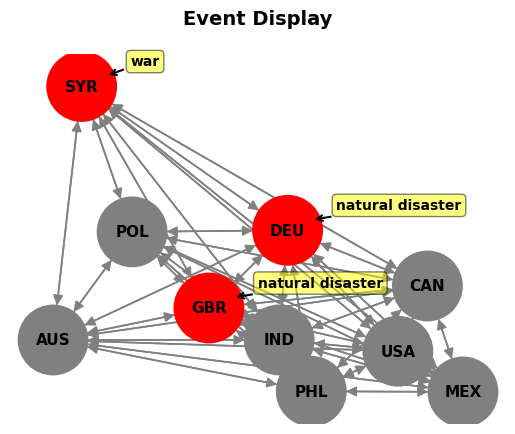

In [25]:
print(world.get_node("USA")["event"])

pos = nx.spring_layout(world.world_graph, k=2, iterations=50, seed=99) # Create spring layout again for consistent node positions

# Build event based colouring:
node_colours = []
for node in world.world_graph.nodes:
    if(world.get_node(node)["event"]):
        # If there's an event
        node_colours.append('Red')
        
        # Also add an annotation
        x, y = pos[node]

        plt.annotate(
        world.get_node(node)["event"]["type"],
        xy=(x+0.05, y+0.05),                  # Pointing to the node. Slight offset
        xytext=(x + 0.1, y + 0.1),  # Position of text box (adjust for your graph)
        textcoords='data',
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5),  # callout box style
        arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
        fontsize=10,
        fontweight='bold'
    )
    else:
        node_colours.append('Gray')

nx.draw(world.world_graph, pos, with_labels=True, cmap='YlOrRd', node_color=node_colours, node_size=2500, font_size=11, font_weight='bold', arrows=True, arrowsize=15, edge_color='gray', width=1.2)



plt.title("Event Display\n", fontsize=14, fontweight='bold')
plt.show()